In [2]:
import pandas as pd
df = pd.read_parquet('../data_acq/objective_data.parquet')
print('unique matches: ', df['matchId'].nunique())
df

unique matches:  56217


,damageTypeRatio,goldDifference,averageAllyLvl,averageEnemyLvl,averageAllyToFountain,averageEnemytoFountain,alliedDragons,enemyDragons,alliedGrubs,enemyGrubs,...,enemyCCScore,isSquishy,vsSquishy,won,objective,team,matchId,patch,rank,region
0,6.115942,-1634.0,5.0,4.8,10358.471587,9639.596728,0,0,0,0,...,6,0,0,0,grub,200,KR_7558776166,15.5,platinum,kr
1,6.115942,-1634.0,5.0,5.4,10358.471587,9639.596728,0,0,1,0,...,6,0,0,0,grub,200,KR_7558776166,15.5,platinum,kr
2,6.115942,-1634.0,5.0,5.4,10358.471587,9639.596728,0,0,2,0,...,6,0,0,0,grub,200,KR_7558776166,15.5,platinum,kr
3,0.816602,3760.0,6.8,6.0,10360.075432,8201.171149,0,0,0,3,...,12,0,0,1,WATER_DRAGON,100,KR_7558776166,15.5,platinum,kr
4,0.695771,4738.4,7.8,6.8,10305.428423,9333.558868,1,0,0,3,...,12,0,0,1,grub,100,KR_7558776166,15.5,platinum,kr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144237,1.450616,1044.0,10.2,9.8,10616.024193,8930.446637,2,0,6,0,...,10,0,1,1,botT1,100,KR_7576353028,15.6,grandmaster,kr
2144238,1.401222,1612.0,10.8,10.0,9899.570191,8454.252144,2,0,6,0,...,10,0,1,1,riftHerald,100,KR_7576353028,15.6,grandmaster,kr
2144239,1.401222,2999.4,11.0,10.4,9899.570191,8454.252144,2,0,6,0,...,10,0,1,1,midT1,100,KR_7576353028,15.6,grandmaster,kr
2144240,1.401222,3499.4,11.2,10.4,9899.570191,8454.252144,2,0,6,0,...,10,0,1,1,midT2,100,KR_7576353028,15.6,grandmaster,kr


In [164]:
def prediction_columns(df: pd.DataFrame):
    return df.drop(columns=['won', 'objective', 'matchId', 'patch', 'region'])

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
import scipy.stats as st

match_list = df['matchId'].unique()
train_matches, test_matches = train_test_split(match_list, test_size=.5)

df_train = df[df['matchId'].isin(train_matches)]
df_test = df[df['matchId'].isin(test_matches)]

for size in [.60, .70, .80, .90, 1]:
    ece_scores = []
    for i in range(0,10):
        sample = df_train.sample(frac=size)

        X_train = prediction_columns(sample)
        y_train = sample['won']

        X_test = prediction_columns(df_test)
        y_test = df_test['won']


        model = CatBoostClassifier(cat_features=['soulType', 'team', 'rank'],
                            depth=4, 
                            learning_rate=0.05, 
                            early_stopping_rounds=50,
                            loss_function='Logloss',
                                eval_metric='Logloss',
                                task_type="GPU",
                                devices='0',
                                verbose=False)
        model.fit(X_train, y_train, eval_set=(X_test, y_test))

        y_preds = [item[1] for item in model.predict_proba(X_test)]
        ratio_true_1s, avg_preds = calibration_curve(y_true=y_test, y_prob=y_preds, n_bins=30)
        bin_counts = np.histogram(y_preds, bins=30)[0]
        ece = np.sum(bin_counts / len(y_test) * np.abs(ratio_true_1s - avg_preds))
        ece_scores.append(ece)
    
    
    mean_ece = np.mean(ece_scores)
    sem = st.sem(ece_scores)
    ci_lower, ci_upper = st.t.interval(0.95, len(ece_scores)-1, loc=mean_ece, scale=sem)
    print(f"Size: {size} | Mean ECE: {mean_ece:.4f} | 95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")


In [172]:
pd.Series(index=X_train.columns, data=model.get_feature_importance()).sort_values(ascending=False)

goldDifference            42.126387
alliedDragons              9.899739
enemyDragons               7.591043
avgEnemyRespawn            6.758658
atakhan                    6.320431
averageAllyLvl             2.903305
averageEnemyLvl            2.808478
avgAlliedRespawn           2.108393
damageTypeRatio            1.800615
CCScore                    1.765591
enemyCCScore               1.609082
tillEnemyNT2               1.571528
alliedGrubs                0.995233
tillEnemyMidInhib          0.958692
team                       0.842095
untilBaronExp              0.831600
averageEnemytoFountain     0.818124
enemyGrubs                 0.708210
averageAllyToFountain      0.574363
topTurrets                 0.558593
untilGrubsSpawn            0.512748
vsSquishy                  0.512039
rank                       0.482846
tillEnemyNT1               0.454888
hasSoul                    0.444025
untilBaronSpawn            0.413967
untilDragonSpawn           0.361578
isSquishy                  0

In [16]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool, cv
import scipy.stats as st
import seaborn as sns

match_list = df['matchId'].unique()
train_matches, test_matches = train_test_split(match_list, test_size=.5)

df_train = df[df['matchId'].isin(train_matches)]
df_test = df[df['matchId'].isin(test_matches)]

X_train = df_train.drop(columns=['won', 'objective', 'matchId', 'patch', 'region'])
y_train = df_train['won']

X_test = df_test.drop(columns=['won', 'objective', 'matchId', 'patch', 'region'])
y_test = df_test['won']


model = CatBoostClassifier(cat_features=['soulType', 'team', 'rank'],
                    depth=4, 
                    learning_rate=0.05, 
                    early_stopping_rounds=50,
                    loss_function='Logloss',
                        eval_metric='Logloss',
                        task_type="GPU",
                        devices='0',
                        verbose=False)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

y_preds = [item[1] for item in model.predict_proba(X_test)]
ratio_true_1s, avg_preds = calibration_curve(y_true=y_test, y_prob=y_preds, n_bins=30)

bin_errors = ratio_true_1s - avg_preds
bin_counts = np.histogram(y_preds, bins=30)[0]
ece = np.sum(bin_counts / len(y_test) * np.abs(bin_errors))
print(ece)

0.0034693440060993416


ECE:  0.0034693440060993416


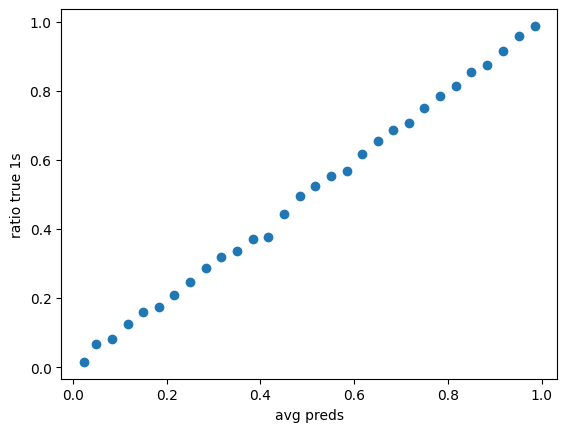

In [209]:
print('ECE: ', ece)
plt.scatter(avg_preds, ratio_true_1s)
plt.xlabel("avg preds")
plt.ylabel("ratio true 1s")
plt.show()

In [207]:
from scipy.stats import shapiro, ttest_1samp
import pickle
with open('low_ece.pkl', 'rb') as file:
    best_model = pickle.load(file)

df_test = pd.read_parquet('test_set.parquet')
subsets = np.array_split(df_test.sample(frac=1), 30)

model_errors = []
for sub in subsets:
    y_preds = [item[1] for item in model.predict_proba(prediction_columns(sub))]
    ratio_true_1s, avg_preds = calibration_curve(y_true=sub['won'], y_prob=y_preds, n_bins=30)

    bin_errors = ratio_true_1s - avg_preds
    model_errors.append(bin_errors)

data = pd.DataFrame(model_errors, columns=list(range(1,31)))

def test_norm_c0(sample: pd.Series):
    stat, p = shapiro(sample)
    if p > .05:
        norm = '✅normal'
    else:
        norm = '❌ not normal'

    stat, p_val = ttest_1samp(sample, popmean=0)
    if p_val > .05:
        centered = '✅centered at 0'
    else:
        centered = '❌ not centered at 0'
    
    return f'{norm} - {centered}'

data.apply(test_norm_c0, axis=0)

c:\Users\Luke\Desktop\SELF_LEARNING\LoL_Objective_Strength\.venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


1               ✅normal - ✅centered at 0
2          ✅normal - ❌ not centered at 0
3               ✅normal - ✅centered at 0
4               ✅normal - ✅centered at 0
5     ❌ not normal - ❌ not centered at 0
6               ✅normal - ✅centered at 0
7               ✅normal - ✅centered at 0
8               ✅normal - ✅centered at 0
9          ✅normal - ❌ not centered at 0
10              ✅normal - ✅centered at 0
11              ✅normal - ✅centered at 0
12         ✅normal - ❌ not centered at 0
13         ✅normal - ❌ not centered at 0
14         ✅normal - ❌ not centered at 0
15              ✅normal - ✅centered at 0
16         ✅normal - ❌ not centered at 0
17    ❌ not normal - ❌ not centered at 0
18              ✅normal - ✅centered at 0
19              ✅normal - ✅centered at 0
20              ✅normal - ✅centered at 0
21         ✅normal - ❌ not centered at 0
22              ✅normal - ✅centered at 0
23         ✅normal - ❌ not centered at 0
24              ✅normal - ✅centered at 0
25              

### Simulate objective capture and find win delta

In [188]:
def simulate_obj(row):
    obj = row['objective']

    if obj in ['EARTH_DRAGON', 'CHEMTECH_DRAGON', 'WATER_DRAGON', 
            'FIRE_DRAGON', 'AIR_DRAGON', 'HEXTECH_DRAGON']:
        row['alliedDragons'] += 1
        row['untilDragonSpawn'] = 300
        row['goldDifference'] += 25

    elif obj in ['Chemtech_dragon_soul', 'Cloud_dragon_soul', 'Hextech_dragon_soul',
                'Mountain_dragon_soul', 'Ocean_dragon_soul', 'Infernal_dragon_soul']:
        row['alliedDragons'] += 1
        row['untilDragonSpawn'] = np.nan
        row['untilElderSpawn'] = 360
        row['goldDifference'] += 25
        row['hasSoul'] = 1


    elif obj == 'atakhan':
        row['atakhan'] = 1
        row['goldDifference'] += 275

    elif obj == 'riftHerald':
        row['killedHerald'] = 1
        row['goldDifference'] += 200


    elif obj == 'nexusTurret':
        if row['tillEnemyNT1'] == 0:
            row['tillEnemyNT1'] = 180
        else:
            row['tillEnemyNT2'] = 180
        row['goldDifference'] += 250

    elif obj == 'baron':
        row['untilBaronExp'] = 180
        row['untilBaronSpawn'] = 360
        row['goldDifference'] += 1525

    elif obj == 'midInhib':
        row['tillEnemyMidInhib'] = 300
    
    elif obj == 'topInhib':
        row['tillEnemyTopInhib'] = 300

    elif obj == 'botInhib':
        row['tillEnemyBotInhib'] = 300

    elif obj in ['midT1', 'midT2', 'midT3']:
        row['enemyMidTurrets'] -= 1
        if 'T1' in obj:
            row['goldDifference'] += 500
        if 'T2' in obj:
            row['goldDifference'] += 550
        if 'T3' in obj:
            row['goldDifference'] += 500
    
    elif obj in ['botT1', 'botT2', 'botT3']:
        row['enemyBotTurrets'] -= 1
        if 'T1' in obj:
            row['goldDifference'] += 500
        if 'T2' in obj:
            row['goldDifference'] += 800
        if 'T3' in obj:
            row['goldDifference'] += 500
    
    elif obj in ['topT1', 'topT2', 'topT3']:
        row['enemytopTurrets'] -= 1
        if 'T1' in obj:
            row['goldDifference'] += 500
        if 'T2' in obj:
            row['goldDifference'] += 800
        if 'T3' in obj:
            row['goldDifference'] += 500
    
    elif obj == 'elder':
        row['untilElderExp'] = 150
        row['untilElderSpawn'] = 360
        row['goldDifference'] += 1350

    
    elif obj == 'grub':
        row['alliedGrubs'] += 1
        if (row['alliedGrubs'] + row['enemyGrubs']) % 3 == 0: 
            if row['minutesElapsed'] < 11.75:
                row['untilGrubsSpawn'] = 240
            else:
                row['untilGrubsSpawn'] = np.nan
        row['goldDifference'] += 25
        
    elif obj == 'feats':
        row['featsOfStrength'] = 1

    return row


def find_win_deltas(df: pd.DataFrame, model: CatBoostClassifier) -> pd.DataFrame:
    df = df.copy(deep=True)

    df['pre_pred'] = [item[1] for item in model.predict_proba(prediction_columns(df))]
    
    post_df = df.apply(simulate_obj, axis=1)

    df['post_pred'] = [item[1] for item in model.predict_proba(prediction_columns(post_df))] 
    
    differences = df['post_pred'] - df['pre_pred']

    df['win_delta'] = differences

    return df


### Find confidence intervals

#### merge bins until sufficient obs

In [180]:
def merge_small_bins(df: pd.DataFrame) -> pd.DataFrame:
    merged = []
    bin_edges = np.linspace(0, 1, 31)
    for obj, group in df.groupby('objective'):

        group = group.copy()
        group['bucket'] = pd.cut(group['pre_pred'], bins=bin_edges)
        counts = group['bucket'].value_counts().sort_index()

        bins = counts.index.tolist()
        merged_bins = []
        current_bin = None
        current_count = 0

        for b in bins:
            if current_bin is None:
                current_bin = b
                current_count = counts[b]  
            else:
                current_count += counts[b]
            
            if current_count < 30:
                continue
            new_bin = pd.Interval(left=current_bin.left, right=b.right, closed='right')
            merged_bins.append((new_bin, current_count))
            current_bin = None
            current_count = 0
        
        if current_bin is not None:
            new_bin = pd.Interval(left=current_bin.left, right=current_bin.right, closed='right')
            merged_bins.append((new_bin, current_count))
        
        # Re-bin the original rows using merged bin edges
        edges = sorted(set([bin[0].left for bin in merged_bins] + [merged_bins[-1][0].right]))
        group['merged_bucket'] = pd.cut(group['pre_pred'], bins=edges, include_lowest=True)

        merged.append(group)
    
    return pd.concat(merged)

In [ ]:
def calc_mean_ci(bucket_stats: pd.DataFrame) -> dict:
    stats = {}
    for obj, group in bucket_stats.groupby('objective'):
        # calcaulte weighted mean
        n_observations_obj = group['n'].sum()
        means = group['m']
        n_observations_buckets = group['n']

        bucket_weighted_means = np.sum(n_observations_buckets * means) / n_observations_obj

        # calculate ci
        bucket_variences = group['var'] 
        objective_varience = np.sum(np.multiply(n_observations_buckets, bucket_variences)) / (n_observations_obj ** 2)

        z = 1.96 # for 95% ci

        left = bucket_weighted_means - (z * np.sqrt(objective_varience))
        right = bucket_weighted_means + (z * np.sqrt(objective_varience))
        ci = pd.Interval(left, right)

        stats[obj] = (bucket_weighted_means, ci )
        
    return stats

In [ ]:
def analyze(predicted_df: pd.DataFrame) -> pd.DataFrame:

    bin_edges = np.linspace(0, 1, 31)
    predicted_df['bucket'] = pd.cut(predicted_df['pre_pred'], bins=bin_edges)
    
    sample_merged = merge_small_bins(predicted_df)

    bucket_stats = (sample_merged.groupby(['objective','merged_bucket'])['win_delta']
        .agg(n='count', m='mean', var = lambda x: x.var(ddof=1))
        .reset_index()
    )
    dct = calc_mean_ci(bucket_stats)
    
    data = (pd.DataFrame(index=dct.keys(), 
                    data=np.array([[value[0] for value in dct.values()], 
                                    [value[1] for value in dct.values()]]).T,
                    columns=['mean', 'confidence'])
            .sort_values(by='mean', ascending=False))

    return data

def bootstrap_mean_ci(predicted_df: pd.DataFrame):
    """
    DO THIS NEXT?????
    https://chatgpt.com/c/67fea768-2020-800b-942d-e7555ce39f5d
    """
    return 

In [189]:
import pickle

with open("low_ece.pkl", "rb") as f:
    best_model = pickle.load(f)

test_set = pd.read_parquet('test_set.parquet')

predicted_df = find_win_deltas(test_set, best_model)

In [193]:
analyze(predicted_df)

,mean,confidence
elder,0.068345,"(0.06713811357113991, 0.06955247622516308]"
baron,0.066377,"(0.06612238441220797, 0.06663176989745212]"
atakhan,0.05941,"(0.059262352298634365, 0.05955790044696633]"
WATER_DRAGON,0.043087,"(0.04282868224675913, 0.043344891318704636]"
AIR_DRAGON,0.042943,"(0.04269041809981542, 0.04319623190875658]"
HEXTECH_DRAGON,0.042443,"(0.042184596981823384, 0.042702198354139694]"
CHEMTECH_DRAGON,0.042405,"(0.0421337577521114, 0.0426770842026171]"
FIRE_DRAGON,0.042391,"(0.042136661665459034, 0.042644850486348175]"
EARTH_DRAGON,0.041888,"(0.04164587085161448, 0.0421305742170184]"
Mountain_dragon_soul,0.033835,"(0.033465498593308496, 0.03420434415056815]"
